In [ ]:
#all_skip

# Image Segmentation with CAMVID
> A basic segmentation example for CAMVID

In [ ]:
import torch

In [ ]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.CAMVID)

In [ ]:
valid_fnames = (path/'valid.txt').read_text().split('\n')

In [ ]:
def ListSplitter(valid_items):
    def _inner(items):
        val_mask = tensor([o.name in valid_items for o in items])
        return [~val_mask,val_mask]
    return _inner

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
                   batch_tfms=[*aug_transforms(size=(360,480)), Normalize.from_stats(*imagenet_stats)])

dls = camvid.dataloaders(path/"images", bs=8)

/home/jhoward/miniconda3/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/jhoward/miniconda3/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A

In [ ]:
dls = SegmentationDataLoaders.from_label_func(path, bs=8,
    fnames = get_image_files(path/"images"), 
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',                                     
    codes = codes,                         
    batch_tfms=[*aug_transforms(size=(360,480)), Normalize.from_stats(*imagenet_stats)])

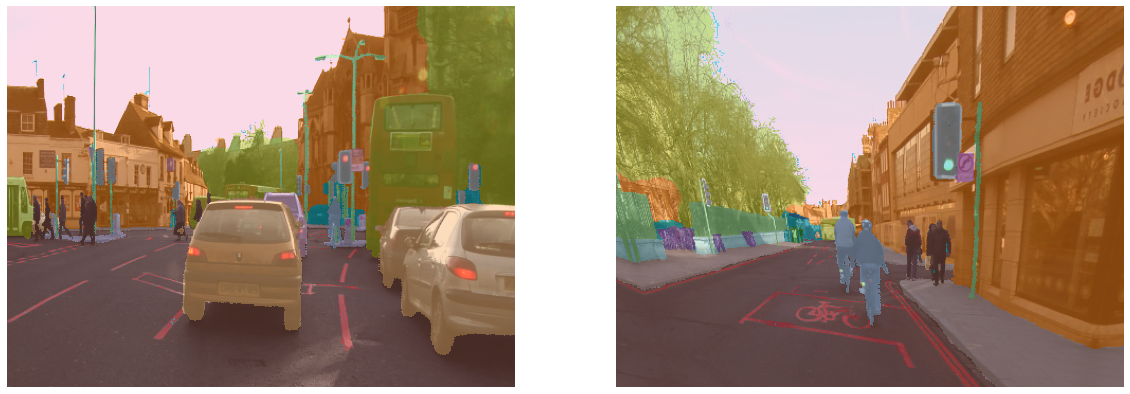

In [ ]:
dls.show_batch(max_n=2, figsize=(20, 7))

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
dls.vocab = codes

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
opt_func = partial(Adam, lr=3e-3, wd=0.01)#, eps=1e-8)

learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), opt_func=opt_func, path=path, metrics=acc_camvid,
                     norm_type=None, wd_bn_bias=True)

/home/jhoward/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
get_c(dls)

32

SuggestedLRs(valley=0.00010964782268274575)

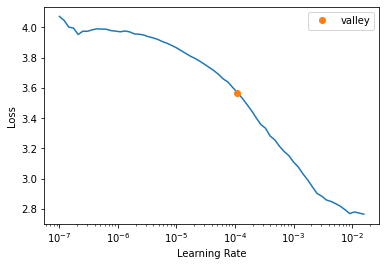

In [ ]:
learn.lr_find()

In [ ]:
lr= 3e-3
learn.freeze()

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9, wd=1e-2)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.200469,0.869627,0.769983,00:57
1,0.840649,0.809244,0.776909,00:47
2,0.716685,0.638332,0.838415,00:47
3,0.670508,0.551083,0.851559,00:47
4,0.664709,0.588863,0.849711,00:47
5,0.603191,0.502482,0.867659,00:47
6,0.592773,0.507730,0.869631,00:47
7,0.541870,0.540163,0.863005,00:47
8,0.531527,0.429516,0.878525,00:47
9,0.463456,0.345390,0.900292,00:47


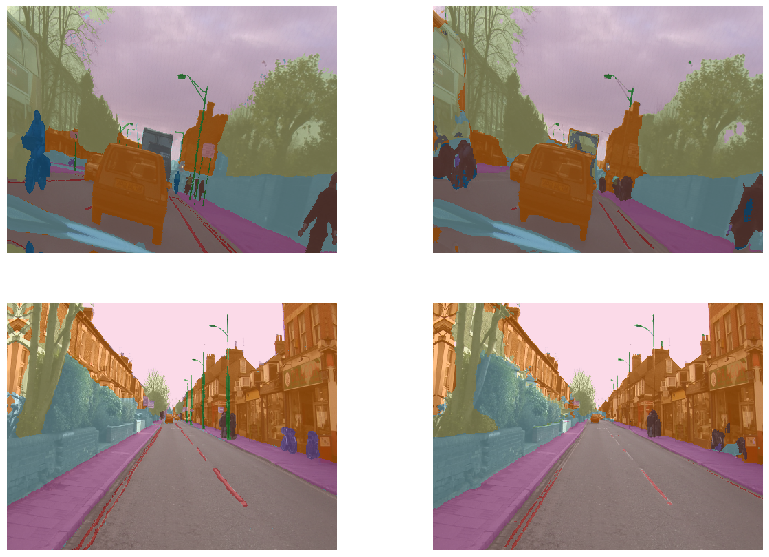

In [ ]:
learn.show_results(max_n=2, rows=2, vmin=1, vmax=30, figsize=(14, 10))

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1')
learn.unfreeze()

In [ ]:
#learn.opt.clear_state() #Not necessarily useful

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8, wd=1e-2)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.415170,0.350871,0.897328,00:42
1,0.405012,0.341905,0.899924,00:42
2,0.400426,0.330662,0.904413,00:42
3,0.385431,0.329282,0.904444,00:42
4,0.372985,0.322414,0.912512,00:42
5,0.366623,0.306477,0.916740,00:42
6,0.362156,0.298581,0.913030,00:42
7,0.343045,0.290931,0.919178,00:42
8,0.327369,0.295092,0.921611,00:42
9,0.334783,0.280629,0.922483,00:42


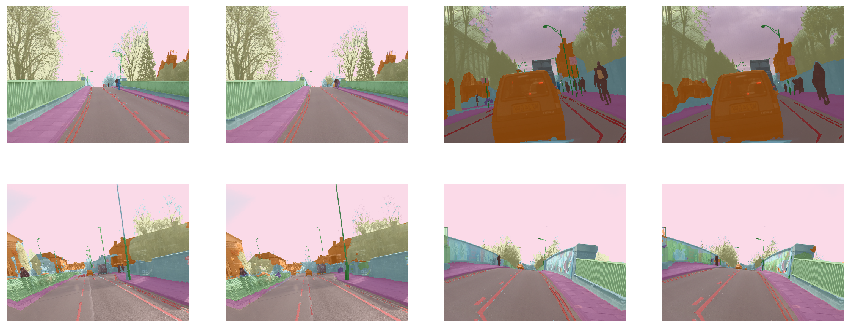

In [ ]:
learn.show_results(max_n=4, vmin=1, vmax=30, figsize=(15,6))